In [10]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import numpy as np
import json
import os

np.set_printoptions(threshold=np.inf)

fileName = './data/DSL-StrongPasswordData.xls'
df_oral = pd.read_excel(fileName)
df_oral = df_oral[(df_oral['subject']== 's002') | (df_oral['subject']== 's032') | (df_oral['subject']== 's036') | (df_oral['subject']== 's047') | (df_oral['subject']== 's052')] 

ud_features = [column for column in df_oral.columns if 'UD' in column]
dd_features = [column for column in df_oral.columns if 'DD' in column]

object_user = 's002'
#object_user = 's032'
#object_user = 's036'
#object_user = 's047'
#object_user = 's052'

df_oral.loc[df_oral['subject']!=object_user,'subject'] = 'imposter'
df = df_oral

#df = df_oral.loc[(df_oral['subject']==object_user) | (df_oral['sessionIndex']<=4)]

#print (df) 
###################################PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder,LabelEncoder

le = LabelEncoder()
df['target'] = le.fit_transform(df['subject'])
df.drop(['subject'], axis=1, inplace=True)

X = df.drop(['target','rep','sessionIndex'], axis=1)[ud_features+dd_features]
y = df['target'].values

ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X)

将样本分为训练集和测试集

In [11]:
'''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=19, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
'''

#s002
index_train1 = [i for i in range(200)]    #s002
index_train2 = [i+400 for i in range(50)] #s032
index_train3 = [i+800 for i in range(50)] #s036
index_train4 = [i+1200 for i in range(50)] #s047
index_train5 = [i+1600 for i in range(50)] #s052

index_test1 = [i+200 for i in range(200)] #s002
index_test2 = [i+450 for i in range(350)]  #s032
index_test3 = [i+850 for i in range(350)]  #s036
index_test4 = [i+1250 for i in range(350)]  #s047
index_test5 = [i+1650 for i in range(350)]  #s052

'''
#s032
index_train1 = [i+100 for i in range(200)] #s032
index_train2 = [i for i in range(50)] #s002
index_train3 = [i+500 for i in range(50)] #s036
index_train4 = [i+600 for i in range(50)] #s047
index_train5 = [i+700 for i in range(50)] #s052

index_test1 = [i+300 for i in range(200)] #s032
index_test2 = [i+50 for i in range(50)]  #s002
index_test3 = [i+550 for i in range(50)]  #s036
index_test4 = [i+650 for i in range(50)]  #s047
index_test5 = [i+750 for i in range(50)]  #s052
'''

'''
#s036
index_train1 = [i+200 for i in range(200)] #s036
index_train2 = [i for i in range(50)] #s002
index_train3 = [i+100 for i in range(50)] #s032
index_train4 = [i+600 for i in range(50)] #s047
index_train5 = [i+700 for i in range(50)] #s052

index_test1 = [i+400 for i in range(200)] #s036
index_test2 = [i+50 for i in range(50)]  #s002
index_test3 = [i+150 for i in range(50)]  #s032
index_test4 = [i+650 for i in range(50)]  #s047
index_test5 = [i+750 for i in range(50)]  #s052
'''
'''
#s047
index_train1 = [i+300 for i in range(200)] #s047
index_train2 = [i for i in range(50)] #s002
index_train3 = [i+100 for i in range(50)] #s032
index_train4 = [i+200 for i in range(50)] #s036
index_train5 = [i+700 for i in range(50)] #s052

index_test1 = [i+500 for i in range(200)] #s047
index_test2 = [i+50 for i in range(50)]  #s002
index_test3 = [i+150 for i in range(50)]  #s032
index_test4 = [i+250 for i in range(50)]  #s036
index_test5 = [i+750 for i in range(50)]  #s052
'''
'''
#s052
index_train1 = [i+400 for i in range(200)] #s052
index_train2 = [i for i in range(50)] #s002
index_train3 = [i+100 for i in range(50)] #s032
index_train4 = [i+200 for i in range(50)] #s036
index_train5 = [i+300 for i in range(50)] #s047

index_test1 = [i+600 for i in range(200)] #s052
index_test2 = [i+50 for i in range(50)]  #s002
index_test3 = [i+150 for i in range(50)]  #s032
index_test4 = [i+250 for i in range(50)]  #s036
index_test5 = [i+350 for i in range(50)]  #s047
'''

index_train = index_train1 + index_train2 + index_train3 + index_train4 + index_train5
index_test = index_test1 + index_test2 + index_test3 + index_test4 + index_test5

X_train = X.iloc[index_train]
X_test = X.iloc[index_test]
y_train = y[index_train]
y_test = y[index_test]

度量选择（AUC）

In [14]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def custom_multi_roc_auc_score(y_true, y_pred, avg='macro'):

    lb = LabelBinarizer()
    return roc_auc_score(lb.fit_transform(y_true), y_pred, average=avg)

multi_roc_auc_scorer = make_scorer(custom_multi_roc_auc_score, needs_proba=True)

设置交叉验证，选择分类模型的参数

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
strtf_cv = StratifiedKFold(n_splits=4, random_state=17)

def plot_cv_results(grid, param='param_n_neighbors', scale='linear'):
    '''
    This function plots gridsearch results for given grid search object. It can only plot 
    results for one parameter (default parameter is C).
    '''
    plt.figure(figsize=(10,6))
    plt.plot(grid.cv_results_[param].tolist(), grid.cv_results_['mean_train_score'], label='Train Score')
    plt.fill_between(grid.cv_results_[param].tolist(), 
                     grid.cv_results_['mean_train_score'] - grid.cv_results_['std_train_score']/2, 
                     grid.cv_results_['mean_train_score'] + grid.cv_results_['std_train_score']/2, 
                     alpha=.3)
    plt.plot(grid.cv_results_[param].tolist(), grid.cv_results_['mean_test_score'], label='Validation Score')
    plt.fill_between(grid.cv_results_[param].tolist(), 
                     grid.cv_results_['mean_test_score'] - grid.cv_results_['std_test_score']/2, 
                     grid.cv_results_['mean_test_score'] + grid.cv_results_['std_test_score']/2, 
                     alpha=.3)
    plt.ylabel('ROC AUC')
    plt.xlabel(param.strip('param_'))
    plt.title('Validation Curve')
    plt.legend()
    plt.xscale(scale)
    plt.show()

KNN分类器

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1)

knn_params = {
    'n_neighbors': list(np.arange(1, 10)) + list(np.linspace(10,180, 15, dtype=int))
}

knn_grid = GridSearchCV(knn_clf, param_grid=knn_params, n_jobs=-1, scoring=multi_roc_auc_scorer, cv=strtf_cv)


In [17]:
%%time
knn_grid.fit(X_train, y_train)
print('ROC AUC的最佳值:', knn_grid.best_score_)
print('最佳参数:', knn_grid.best_params_)

ROC AUC的最佳值: 0.7892
最佳参数: {'n_neighbors': 8}
Wall time: 10.5 s


In [43]:
#检查模型的质量（ROC AUC）的延迟数据
#custom_multi_roc_auc_score(y_test, knn_grid.best_estimator_.predict_proba(X_test))
y_score_KNN1=knn_grid.best_estimator_.predict(X_test)
ann_fileName = "KNN1_best"+object_user+"_CMU_pred.txt"
np.savetxt(ann_fileName, np.array(y_score_KNN1))

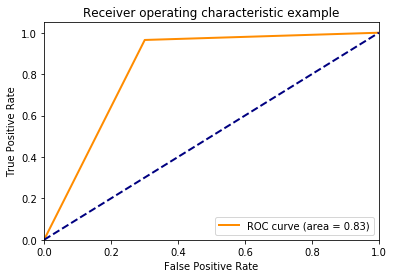

In [21]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



改变了曼哈顿的距离的度量

In [36]:
knn_clf = KNeighborsClassifier(p=1, n_jobs=-1)

knn_params = {
    'n_neighbors': list(np.arange(1, 10)) + list(np.linspace(10, 180, 15, dtype=int))   
}

knn_grid_manhattan = GridSearchCV(knn_clf, param_grid=knn_params, n_jobs=-1, scoring=multi_roc_auc_scorer, cv=strtf_cv)


In [37]:
%%time
knn_grid_manhattan.fit(X_train, y_train)
print('ROC AUC的最佳值:', knn_grid_manhattan.best_score_)
print('最佳参数:', knn_grid_manhattan.best_params_)

ROC AUC的最佳值: 0.76185
最佳参数: {'n_neighbors': 10}
Wall time: 10.5 s


c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


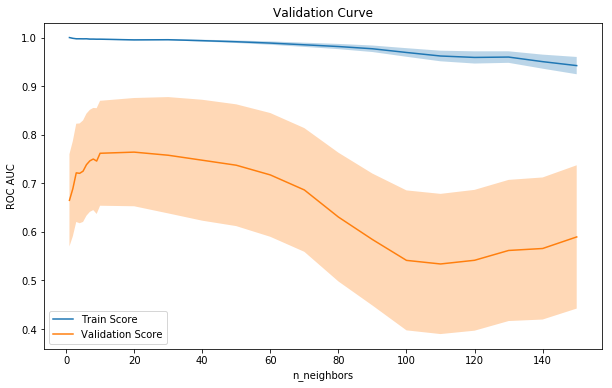

In [24]:
#plot_cv_results(knn_grid_manhattan, param='param_n_neighbors')

In [42]:
y_score_KNN2=knn_grid_manhattan.best_estimator_.predict(X_test)
ann_fileName = "KNN2_best"+object_user+"_CMU_pred.txt"
np.savetxt(ann_fileName, np.array(y_score_KNN2))

In [59]:
#检查模型的质量（ROC AUC）的延迟数据
#custom_multi_roc_auc_score(y_test, knn_grid_manhattan.best_estimator_.predict_proba(X_test))

SVM2

In [31]:
import numpy as np
import sklearn.model_selection as ms
import sklearn.svm as svm
import sklearn.metrics as sm
import matplotlib.pyplot as plt

# 最优超参数组合列表
params = [
        {'kernel': ['linear'], 'C': [1, 10, 100, 100,1000]},
        {'kernel': ['poly'], 'C': [1,10,100], 'degree': [2, 3]},
        {'kernel': ['rbf'], 'C': [1, 10, 100, 100,1000], 'gamma':[1, 0.1, 0.01, 0.001]}
        ]

model = ms.GridSearchCV(svm.SVC(probability=True), 
                        params, 
                        refit=True,
                        return_train_score=True,        # 后续版本需要指定True才有score方法  
                        cv=4)
model.fit(X_train, y_train)

# GridSearchCV的属性
print('Attrabutes:vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv')
print('cv_results_:',model.cv_results_.keys())
print('Desc:',model.cv_results_['params'][2], model.cv_results_['mean_train_score'][2], 
      model.cv_results_['mean_test_score'][2],model.cv_results_['rank_test_score'][2])
print('best_estimator_:',model.best_estimator_) 
print('best_params_:',model.best_params_) 
print('best_params_:', model.cv_results_['params'][model.best_index_])
print('best_score_:',model.best_score_)
print('scorer_:',model.scorer_)
print('n_splits_:',model.n_splits_)

c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The defa

Attrabutes:vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
cv_results_: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'param_degree', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])
Desc: {'C': 100, 'kernel': 'linear'} 0.9891666666666667 0.7975 12
best_estimator_: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best_params_: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
best_params_: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
best_score_: 0.8375
scorer_: <function _passthrough_scorer at 0x000001FF846BF378>
n_splits_: 4

In [41]:
y_predict_SVM = model.best_estimator_.predict(X_test)
ann_fileName = "SVM_best"+object_user+"_CMU_pred.txt"
np.savetxt(ann_fileName, np.array(y_predict_SVM))

神经网络

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

mlp_clf__tuned_parameters = {"hidden_layer_sizes": [(40,),(40,32),(64,),(64,32),(140,),(140,128),(140,32), (140,64),(140,64,32), (256,)],
                             "solver": ['adam', 'sgd', 'lbfgs'],
                             "max_iter": [20,100,200,1000,5000],
                             "verbose": [True]
                             }
mlp = MLPClassifier()
estimator = GridSearchCV(mlp, mlp_clf__tuned_parameters, n_jobs=6)
estimator.fit(X_train, y_train)

print(estimator.get_params().keys()) 
print (estimator.best_params_)

c:\users\jw\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


dict_keys(['cv', 'error_score', 'estimator__activation', 'estimator__alpha', 'estimator__batch_size', 'estimator__beta_1', 'estimator__beta_2', 'estimator__early_stopping', 'estimator__epsilon', 'estimator__hidden_layer_sizes', 'estimator__learning_rate', 'estimator__learning_rate_init', 'estimator__max_iter', 'estimator__momentum', 'estimator__n_iter_no_change', 'estimator__nesterovs_momentum', 'estimator__power_t', 'estimator__random_state', 'estimator__shuffle', 'estimator__solver', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
{'hidden_layer_sizes': (64,), 'max_iter': 1000, 'solver': 'lbfgs', 'verbose': True}


c:\users\jw\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [40]:
y_predict = model.best_estimator_.predict(X_test)
ann_fileName = "ANN_best"+object_user+"_CMU_pred.txt"
np.savetxt(ann_fileName, np.array(y_predict))

In [34]:
# two-layer neural network 
# train part
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from joblib import dump

#neural network classifier of structure (3,2)
kf = KFold(n_splits=4) # 3-fold cross-validation
best_clf = None
best_score = 0
train_scores = []
test_scores = []
print("kfold-------")
for train_index, test_index in kf.split(X):
    # create neural network using MLPClassifer  {sgd,lbfgs, adam}
    clf = MLPClassifier(solver = 'lbfgs', max_iter = 1000, hidden_layer_sizes = (64,),random_state = 1)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    train_scores.append(train_score)
 
    test_score = clf.score(X_test, y_test)
    test_scores.append(test_score)

    #compare score of the tree models and get the best one
    if test_score > best_score:
        best_score = test_score
        best_clf = clf
    
    #print(clf.n_outputs_)
in_sample_error = [1 - score for score in train_scores]
test_set_error = [1 - score for score in test_scores]
print("in_sample_error: ")
print(in_sample_error)
print("test_set_error: ")
print(test_set_error)

#store the classifier
if best_clf != None:
    dump(best_clf, "train_model.m")
    
from joblib import load
clf = load("train_model.m")
y_pred = clf.predict(X_test)
np.savetxt("label_pred.txt", np.array(y_pred)) #save predict result
#print(y_pred)
test_score = clf.score(X_test, y_test)
test_error = 1 - test_score
print('test_score：%s' % test_score)
print('test_error：%s' % test_error)

kfold-------
in_sample_error: 
[0.0, 0.0, 0.0, 0.0]
test_set_error: 
[0.19625000000000004, 0.19625000000000004, 0.19625000000000004, 0.19625000000000004]
test_score：0.80375
test_error：0.19625000000000004


In [39]:
ann_fileName = "ANN_"+object_user+"_CMU_pred.txt"
np.savetxt(ann_fileName, np.array(y_pred))